In [1]:
import os
import sys
sys.path.append('..')

from scripts.data_loaders.common import show_sample
from scripts.data_loaders.L2ARCTIC import L2ArcticDataset
from scripts.data_loaders.TIMIT import TIMITDataset
from scripts.ipa_transcription.wav2vec2 import transcribe_batch
from scripts.eval.evaluate import evaluate

import torch
from transformers import AutoProcessor, AutoModelForCTC

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output
clear_output()

# Load Data

In [2]:
arctic = L2ArcticDataset(split='suitcase_corpus', include_speaker_info=True)
timit = TIMITDataset(split='test', include_speaker_info=True)

IPA: jɛˈsʌˈmɪˈtsiˈmzɪffɹʌˈmðʌfɝˈsbɪˈktʃɝzzɪsɪzlaɪˈkʌbɪˈktʃɝoʊfʌˈmʌdaʊˈntaʊˈnɔfʌsiˈtiwɪˈzʌbɪˈkhɔtɛˈlsʌndtuˈtuˈbiˈpʌlwʌˈnwʊˈmʌnæˈndwʌˈnmæˈnwɛˈnduˈzɪˈshətɛˈlzʌnbɪkʌzzɛˈɹɪˈznoʊsɔɪnʌˈɔˈnzʌɔˈnzʌwɛˈndoʊzɪtʃwʌˈnlaɪˈkɹæˈʒdɪˈntuɪtʃʌˈðɝsʌndɑftɝðæˈtɑftɝkɹæˈʃʌˈðeɪˈfɑnðæˈtsɝbɹaɪˈzɪŋɡɹlizɛhæˈvdʌsɛmkɑˈlɝoʊvzʌbæˈkʌndɪhɪllaɪˈkɪˈtsɪssɪˈmʌlɝbæˈksæˈkʃʌliʌndɑftɹkɹæˈʃɪŋɡɪvɹiwʌˌndoʊˈkzɛiˈtʃʌˈdɹzbæˈkʌndɑftɝðæˈtwɛˈnwɛˈntbæˈktuˈðɛɹɹuˈmzðɛfaʊˈnðæˈtzʌˈmæˈndoʊˈkzʌˈdɹɛˈsɔvzʌˈɑftɝhɪˈzoʊbʌnɪŋtszʌˈzʌˈbæˈkhɪzbæˈkhiˈfʌnzʌthiˈtɔˈkʌˈhiˈfaʊˈndlaɪˈkʌɹɛˈddɹɛˈsɔfʌwʊˈmʌnʌnzʌwʊˈmʌnfɑnzʌtʌˈeɪˈjɪloʊtɔɪʌˈvðʌmæˈnʌndʌmnɑˈtʃʊˈɹwʌˈtswʌˈthæˈbʌnæˈftɝθæˈθ
Metadata: {'gender': 'M', 'native-language': 'Arabic'}


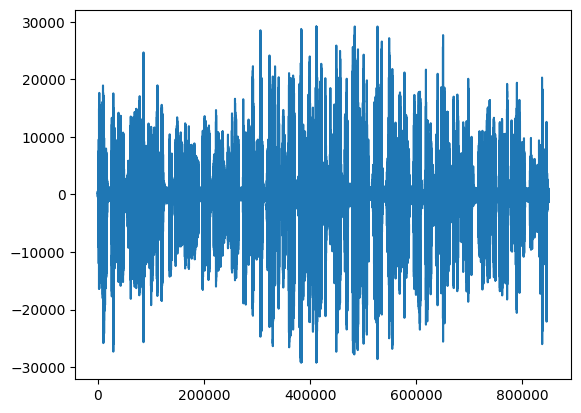

In [3]:
show_sample(arctic[0])

IPA: plizdɪɡmaɪpɪteɪɾoʊzʌpbifɔɹfɹɔst
Metadata: {'SEX': 'M', 'DIALECT': 'Western', 'SPLIT': 'TST', 'RECORDING_DATE': '01/23/86', 'BIRTH_DATE': '04/10/54', 'HEIGHT': '5\'7"', 'RACE': ' WHT', 'EDUCATION': 'BS'}


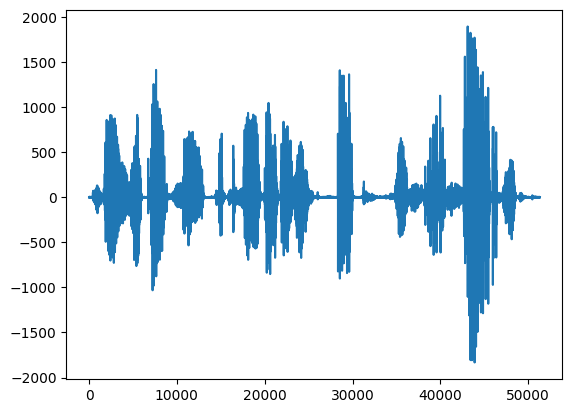

In [4]:
show_sample(timit[1])

# Eval Models

In [5]:
scores = pd.DataFrame(columns=['Model', 'Background', 'Gender', 'Dataset', 'Ground Truth', 'Prediction'])
def run_model(model_name, model_id, dataset_metadata_parse_fn, dataset, device='cpu', batch_size=1):
    global scores

    torch.mps.empty_cache()
    processor = AutoProcessor.from_pretrained(model_id)
    model = AutoModelForCTC.from_pretrained(model_id).to(device)

    amount = len(dataset)
    for i in range(0, amount, batch_size):
        torch.mps.empty_cache()
        size = min(batch_size, amount - i)
        transcriptions = transcribe_batch(dataset[i:i+size], model, processor)
        for j in range(size):
            background, gender, dataset_name = dataset_metadata_parse_fn(dataset[i+j])
            scores = pd.concat([scores, pd.DataFrame([[
                model_name, 
                background,
                gender, 
                dataset_name,
                dataset[i+j][0],
                transcriptions[j]
            ]], columns=scores.columns)])

In [6]:
if not os.path.exists('../.data/scores.csv'):
    for name, model_id in [
        # ("KoelLabs a1", "KoelLabs/xlsr-timit-a1"),
        ("KoelLabs b0", "KoelLabs/xlsr-timit-b0"),
        # ("KoelLabs c0", "KoelLabs/xlsr-timit-c0"),
        # ("KoelLabs d0", "KoelLabs/xlsr-timit-d0"),
        # ("KoelLabs e0", "KoelLabs/xlsr-timit-e0"),
        # ("KoelLabs b1", "KoelLabs/xlsr-timit-b1"),
        # ("KoelLabs c1", "KoelLabs/xlsr-timit-c1"),
        # ("KoelLabs d1", "KoelLabs/xlsr-timit-d1"),
        # ("KoelLabs e1", "KoelLabs/xlsr-timit-e1"),
        ("Taguchi", "ginic/gender_split_70_female_4_wav2vec2-large-xlsr-53-buckeye-ipa"),
        # ("Rubino", "mrrubino/wav2vec2-large-xlsr-53-l2-arctic-phoneme"),
        ("Facebook", "facebook/wav2vec2-lv-60-espeak-cv-ft"),
        # ("Vitouphy", "vitouphy/wav2vec2-xls-r-300m-timit-phoneme")
    ]:
        print(f"Model: {name} ({model_id})")
        print("TIMIT")
        run_model(name, model_id, lambda x: (x[2]['DIALECT'], x[2]['SEX'], 'TIMIT'), timit, 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu', 4)
        print("Arctic")
        run_model(name, model_id, lambda x: (x[2]['native-language'], x[2]['gender'], 'Suitcase'), arctic, 'cpu', 1) 
else:
    scores = pd.read_csv('../.data/scores.csv')

In [8]:
scores[['PER', 'FER']] = scores.apply(lambda x: evaluate(x['Ground Truth'], x['Prediction']), axis=1, result_type='expand')
clear_output()

In [14]:
scores.head()

Model     Background Gender Dataset  \
0  KoelLabs b0       Southern      F   TIMIT   
1  KoelLabs b0  North Midland      M   TIMIT   
2  KoelLabs b0  South Midland      M   TIMIT   
3  KoelLabs b0  North Midland      M   TIMIT   
4  KoelLabs b0      Army Brat      F   TIMIT   

                       Ground Truth                        Prediction  \
0   dɹɑpfaɪfɔɹmzinəbɑksbifɔjugoʊaʊʔ  ɹɑpθaɪfɔɹmzinðəbɑksbifɔɹjiɡoʊaʊt   
1    waɪbaɪʔɔɪəlhwinjuʔoʊwizjuzmaɪn      hwaɪbaɪʔɔɪlwinjuʔɔwɪzjuzmaɪn   
2                   ʃiɪzθɪɾʊðɪnaɪæm                   ʃiɪzθɪɾʌðinaɪæm   
3  ɹɑbsæpbaɪðəpɑndnskɛtʃtðiʃtɹeɪgis  ɹɑbsɛpaɪðəpɑndnskɛttʃtðiʃtɹeɪɡis   
4    bɑɹbɹndpeɪpɹnlivzinəbɪgbɑnfaɪɹ      ɑɹbɹnpeɪpɹinlivziɾəbɪɡɑnfaɪɹ   

        FER       PER  
0  0.057425  0.225806  
1  0.067241  0.200000  
2  0.003448  0.133333  
3  0.032058  0.125000  
4  0.069540  0.200000

In [15]:
scores.to_csv('../.data/scores.csv', index=False)

# Analyze Results

In [16]:
scores[['Model', 'Dataset', 'PER', 'FER']].groupby(['Model', 'Dataset']).agg([('mean', np.mean), ('std', np.std), ('n', np.size)]) # type: ignore

PER                       FER                
                          mean       std     n      mean       std     n
Model       Dataset                                                     
Facebook    Suitcase  1.334285  0.105914    22  0.068774  0.016139    22
            TIMIT     1.207842  0.138028  1680  0.047531  0.022859  1680
KoelLabs b0 Suitcase  0.416744  0.076820    22  0.082159  0.018110    22
            TIMIT     0.131464  0.065057  1680  0.029876  0.019351  1680
Taguchi     Suitcase  0.366894  0.077149    22  0.075344  0.020974    22
            TIMIT     0.255646  0.080220  1680  0.040119  0.021597  1680

In [17]:
scores[['Dataset', 'Background', 'PER', 'FER']].groupby(['Dataset', 'Background']).agg([('mean', np.mean), ('std', np.std), ('n', np.size)]) # type: ignore

PER                      FER               
                            mean       std    n      mean       std    n
Dataset  Background                                                     
Suitcase Arabic         0.687476  0.474944    9  0.070159  0.019007    9
         Chinese        0.690021  0.481056   12  0.072162  0.022495   12
         Hindi          0.810680  0.500728    9  0.091220  0.007858    9
         Korean         0.650048  0.436195   12  0.071841  0.021426   12
         Spanish        0.736138  0.478263   12  0.077088  0.020963   12
         Vietnamese     0.683035  0.468539   12  0.072715  0.012915   12
TIMIT    Army Brat      0.538978  0.505940  330  0.037406  0.022442  330
         New England    0.538027  0.494595  330  0.040888  0.022304  330
         New York City  0.524459  0.489427  330  0.039555  0.024244  330
         North Midland  0.519925  0.495546  780  0.035514  0.020979  780
         Northern       0.523859  0.494463  780  0.038267  0.022760  780
         South Midland  0.540076  0.489012  960  0.041234  0.023858  960
         Southern       0.545228  0.488769  840  0.041607  0.022095  840
         Western        0.522348  0.481253  690  0.038365  0.021076  690

In [18]:
scores[['Model', 'Dataset', 'Background', 'PER', 'FER']].groupby(['Model', 'Dataset', 'Background']).agg([('mean', np.mean), ('std', np.std), ('n', np.size)]) # type: ignore

PER                      FER  \
                                        mean       std    n      mean   
Model       Dataset  Background                                         
Facebook    Suitcase Arabic         1.315956  0.029835    3  0.058223   
                     Chinese        1.328383  0.124182    4  0.067276   
                     Hindi          1.475634  0.050819    3  0.087590   
                     Korean         1.232722  0.075948    4  0.067365   
                     Spanish        1.377396  0.054483    4  0.065718   
                     Vietnamese     1.306371  0.120080    4  0.068541   
            TIMIT    Army Brat      1.234879  0.140969  110  0.047299   
                     New England    1.217596  0.142374  110  0.049900   
                     New York City  1.198049  0.137492  110  0.048337   
                     North Midland  1.204608  0.128616  260  0.044241   
                     Northern       1.205503  0.137321  260  0.047907   
                     South Midland  1.211268  0.141130  320  0.050054   
                     Southern       1.216351  0.145047  280  0.048114   
                     Western        1.186106  0.130866  230  0.045199   
KoelLabs b0 Suitcase Arabic         0.404356  0.064506    3  0.083291   
                     Chinese        0.411921  0.104660    4  0.083461   
                     Hindi          0.514699  0.023497    3  0.093896   
                     Korean         0.369384  0.068076    4  0.074935   
                     Spanish        0.415477  0.070401    4  0.081435   
                     Vietnamese     0.406020  0.068533    4  0.079152   
            TIMIT    Army Brat      0.129294  0.063552  110  0.028471   
                     New England    0.138476  0.069086  110  0.032668   
                     New York City  0.129541  0.065326  110  0.030189   
                     North Midland  0.118472  0.058388  260  0.027445   
                     Northern       0.120538  0.061286  260  0.027886   
                     South Midland  0.135357  0.068076  320  0.029212   
                     Southern       0.146656  0.067524  280  0.033694   
                     Western        0.133197  0.063486  230  0.030337   
Taguchi     Suitcase Arabic         0.342116  0.074889    3  0.068963   
                     Chinese        0.329757  0.051304    4  0.065749   
                     Hindi          0.441709  0.030269    3  0.092175   
                     Korean         0.348037  0.088987    4  0.073222   
                     Spanish        0.415539  0.091361    4  0.084113   
                     Vietnamese     0.336713  0.074312    4  0.070452   
            TIMIT    Army Brat      0.252762  0.089109  110  0.036449   
                     New England    0.258007  0.083857  110  0.040095   
                     New York City  0.245787  0.078687  110  0.040138   
                     North Midland  0.236696  0.075676  260  0.034856   
                     Northern       0.245535  0.072555  260  0.039007   
                     South Midland  0.273604  0.083033  320  0.044435   
                     Southern       0.272678  0.082460  280  0.043013   
                     Western        0.247742  0.073105  230  0.039558   

                                                   
                                         std    n  
Model       Dataset  Background                    
Facebook    Suitcase Arabic         0.008147    3  
                     Chinese        0.016310    4  
                     Hindi          0.007547    3  
                     Korean         0.022950    4  
                     Spanish        0.017254    4  
                     Vietnamese     0.012927    4  
            TIMIT    Army Brat      0.021429  110  
                     New England    0.025131  110  
                     New York City  0.025872  110  
                     North Midland  0.020386  260  
                     Northern       0.023051  260  
                     South 

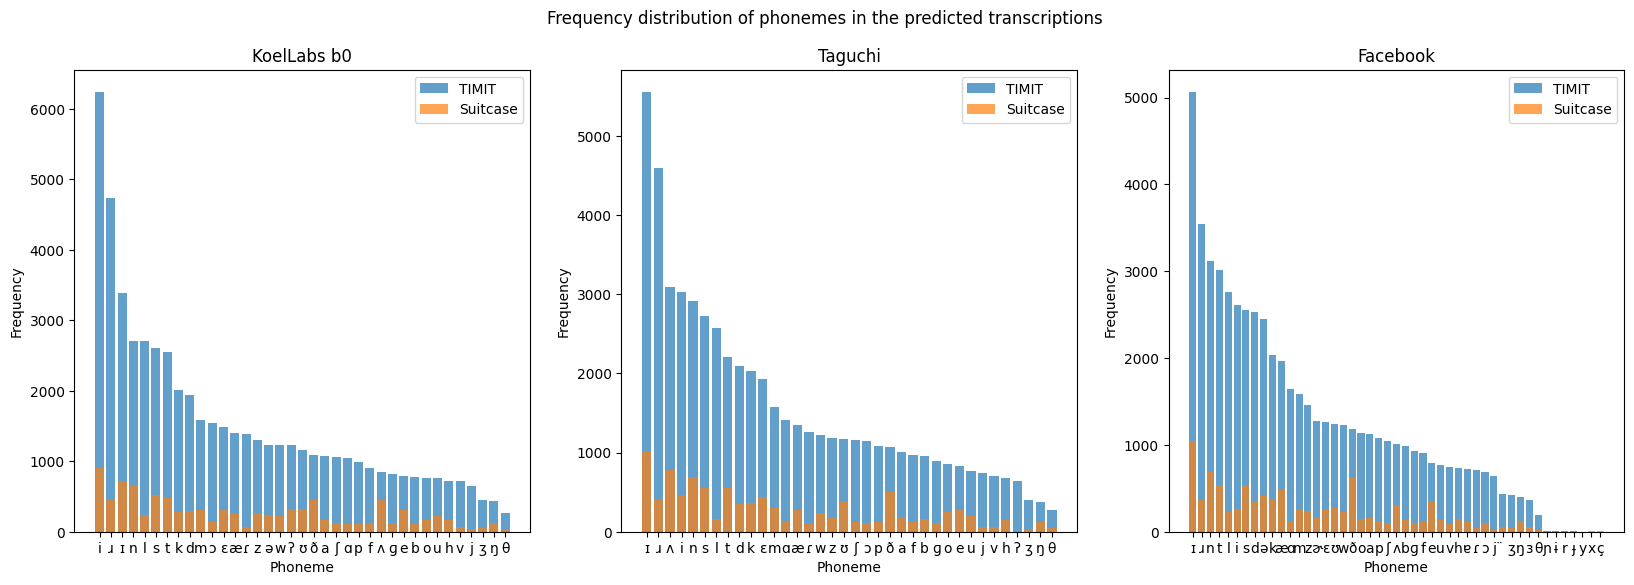

In [19]:
# calculate the frequency distribution of phonemes in the ground truth and predicted transcriptions from scores
from collections import Counter
from scripts.eval.evaluate import preprocess_ipa

def phoneme_distribution(scores, column, model, dataset):
    phoneme_counter = Counter()
    for i, row in scores[(scores['Model'] == model) & (scores['Dataset'] == dataset)].iterrows():
        phoneme_counter.update(preprocess_ipa(row[column]).replace(' ', ''))

    return phoneme_counter

phon_dist = pd.DataFrame(columns=['Dataset', 'Phoneme', 'Frequency'])
for dataset in scores['Dataset'].unique():
    phon_dist = pd.concat([phon_dist, pd.DataFrame([
        [dataset, phoneme, freq]
        for phoneme, freq in phoneme_distribution(scores, 'Ground Truth', scores['Model'][0], dataset).items()
    ], columns=phon_dist.columns)])

phon_dist_by_model = pd.DataFrame(columns=['Model', 'Dataset', 'Phoneme', 'Frequency'])
for model in scores['Model'].unique():
    for dataset in scores['Dataset'].unique():
        phon_dist_by_model = pd.concat([phon_dist_by_model, pd.DataFrame([
            [model, dataset, phoneme, freq]
            for phoneme, freq in phoneme_distribution(scores, 'Prediction', model, dataset).items()
        ], columns=phon_dist_by_model.columns)])

# plot the frequency distribution of phonemes in the ground truth
plt.figure(figsize=(20, 6))
plt.suptitle('Frequency distribution of phonemes in the ground truth transcriptions')
for i, dataset in enumerate(phon_dist['Dataset'].unique()):
    plt.subplot(1, 2, i + 1)
    data = phon_dist[phon_dist['Dataset'] == dataset]
    data = data.sort_values('Frequency', ascending=False)
    plt.bar(data['Phoneme'], data['Frequency'])
    plt.title(dataset)
    plt.xlabel('Phoneme')
    plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(20, 6))
plt.suptitle('Frequency distribution of phonemes in the predicted transcriptions')
for i, model in enumerate(phon_dist_by_model['Model'].unique()):
    plt.subplot(1, 3, i + 1)
    for dataset in phon_dist_by_model['Dataset'].unique():
        data = phon_dist_by_model[(phon_dist_by_model['Model'] == model) & (phon_dist_by_model['Dataset'] == dataset)]
        data = data.sort_values('Frequency', ascending=False)
        plt.bar(data['Phoneme'], data['Frequency'], label=dataset, alpha=0.7)
    plt.title(model)
    plt.xlabel('Phoneme')
    plt.ylabel('Frequency')
    plt.legend()
plt.show()

Observation: the Koel Labs model was trained on the TIMIT train set and learned the phoneme distribution of the TIMIT test set. Phoneme level resampling might be necessary for models to generalize to unseen data.

In [20]:
from scripts.forced_alignment.needleman_wunsch import weighted_needleman_wunsch
weighted_needleman_wunsch('bat', 'phat')

(['b', '-', 'a', 't'], ['p', 'h', 'a', 't'])

In [21]:
scores.reset_index(drop=True, inplace=True)
scores = scores.loc[:, ~scores.columns.str.contains('->')] # drop all columns with -> in the name
for i, row in scores.iterrows():
    missed_phoneme_pairs = {}
    norm_label, norm_pred = preprocess_ipa(row['Ground Truth']), preprocess_ipa(row['Prediction'])
    for pair in zip(*weighted_needleman_wunsch(norm_label, norm_pred)):
        if pair[0] != pair[1]:
            missed_phoneme_pairs[pair] = missed_phoneme_pairs.get(pair, 0) + 1
    # add each phoneme pair as a column to the scores dataframe
    for pair, count in missed_phoneme_pairs.items():
        col = f'{pair[0]}->{pair[1]}'
        if col not in scores.columns:
            scores[col] = 0
        col_index = scores.columns.get_loc(col)
        scores.iat[i, col_index] = count
clear_output()

In [22]:
scores.head()

Model     Background Gender Dataset  \
0  KoelLabs b0       Southern      F   TIMIT   
1  KoelLabs b0  North Midland      M   TIMIT   
2  KoelLabs b0  South Midland      M   TIMIT   
3  KoelLabs b0  North Midland      M   TIMIT   
4  KoelLabs b0      Army Brat      F   TIMIT   

                       Ground Truth                        Prediction  \
0   dɹɑpfaɪfɔɹmzinəbɑksbifɔjugoʊaʊʔ  ɹɑpθaɪfɔɹmzinðəbɑksbifɔɹjiɡoʊaʊt   
1    waɪbaɪʔɔɪəlhwinjuʔoʊwizjuzmaɪn      hwaɪbaɪʔɔɪlwinjuʔɔwɪzjuzmaɪn   
2                   ʃiɪzθɪɾʊðɪnaɪæm                   ʃiɪzθɪɾʌðinaɪæm   
3  ɹɑbsæpbaɪðəpɑndnskɛtʃtðiʃtɹeɪgis  ɹɑbsɛpaɪðəpɑndnskɛttʃtðiʃtɹeɪɡis   
4    bɑɹbɹndpeɪpɹnlivzinəbɪgbɑnfaɪɹ      ɑɹbɹnpeɪpɹinlivziɾəbɪɡɑnfaɪɹ   

        FER       PER  d->-  f->θ  ...  ʒ->ð  ɔ->ʒ  ɡ->ɜ  ð->ɜ  e->ŋ  ɡ->p  \
0  0.057425  0.225806     1     1  ...     0     0     0     0     0     0   
1  0.067241  0.200000     0     0  ...     0     0     0     0     0     0   
2  0.003448  0.133333     0     0  ...     0     0     0     0     0     0   
3  0.032058  0.125000     0     0  ...     0     0     0     0     0     0   
4  0.069540  0.200000     1     0  ...     0     0     0     0     0     0   

   ŋ->ɜ  a->u  ŋ->ɚ  u->a  
0     0     0     0     0  
1     0     0     0     0  
2     0     0     0     0  
3     0     0     0     0  
4     0     0     0     0  

[5 rows x 1529 columns]

In [23]:
# normalize counts based on ground truth phoneme frequencies
phoneme_pairs = [col for col in scores.columns if '->' in col]

scores_norm = scores.copy()
for col in phoneme_pairs:
    phoneme_pair = col.split('->')
    ground_truth_phoneme, _ = phoneme_pair
    ground_truth_phoneme_freq = phon_dist[phon_dist['Phoneme'] == ground_truth_phoneme]
    for dataset in scores['Dataset'].unique():
        dataset_phoneme_freq = ground_truth_phoneme_freq[ground_truth_phoneme_freq['Dataset'] == dataset]
        scores_norm[col] = scores[col].apply(lambda x: x / dataset_phoneme_freq['Frequency'].sum() if dataset_phoneme_freq['Frequency'].sum() > 0 else 0)

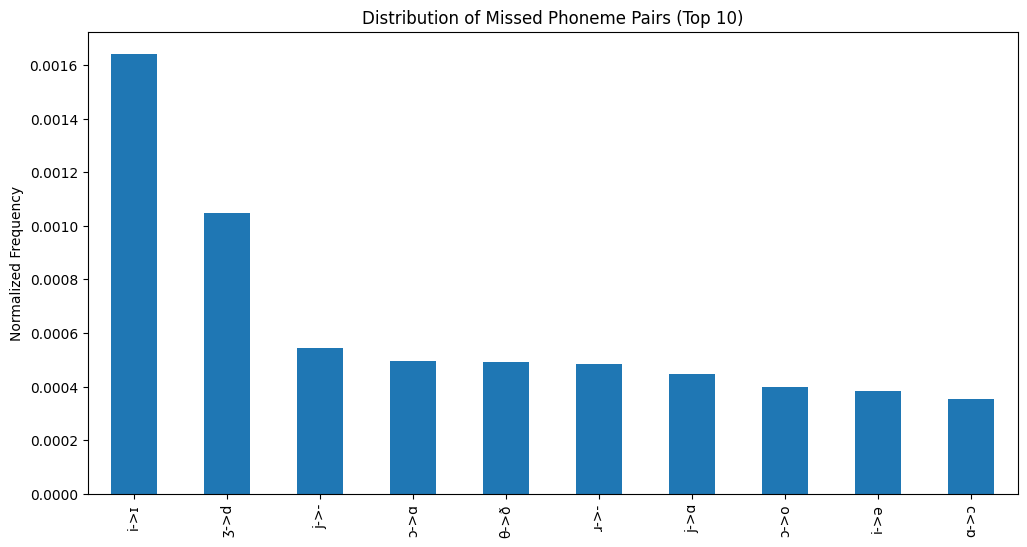

In [24]:
# plot the distribution of phoneme pairs as a bar chart
pair_counts = scores_norm[phoneme_pairs].mean()
pair_counts.sort_values(ascending=False, inplace=True)

# only show the top 10 phoneme pairs
plt.figure(figsize=(12, 6))
pair_counts.head(10).plot(kind='bar')
plt.title('Distribution of Missed Phoneme Pairs (Top 10)')
plt.ylabel('Normalized Frequency')
plt.show()

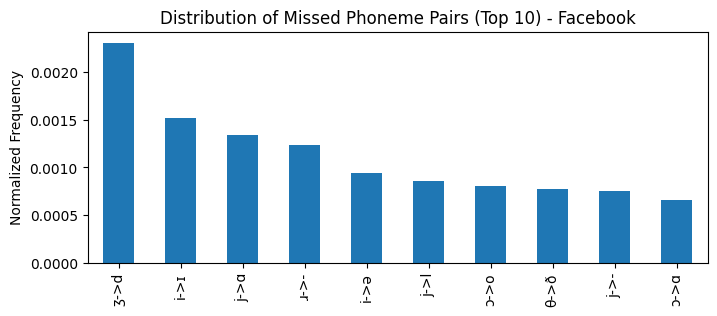

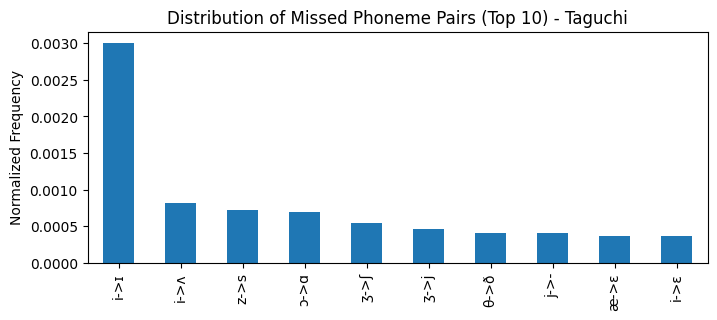

In [25]:
# plot the distribution of phoneme pairs as a bar chart stratified by model
for model, model_scores in scores_norm.groupby('Model'):
    plt.figure(figsize=(8, 3))
    pair_counts = model_scores[phoneme_pairs].mean()
    pair_counts.sort_values(ascending=False, inplace=True)
    pair_counts.head(10).plot(kind='bar')
    plt.title('Distribution of Missed Phoneme Pairs (Top 10) - ' + str(model))
    plt.ylabel('Normalized Frequency')
    plt.show()

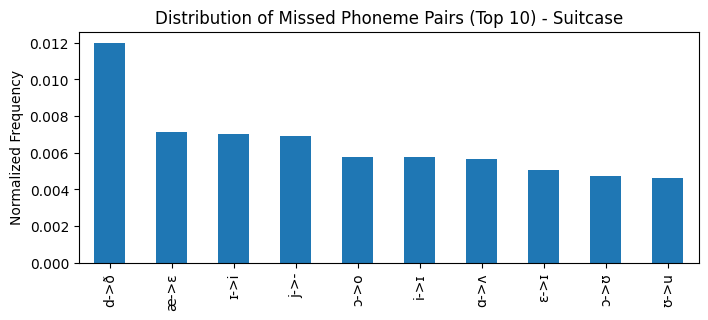

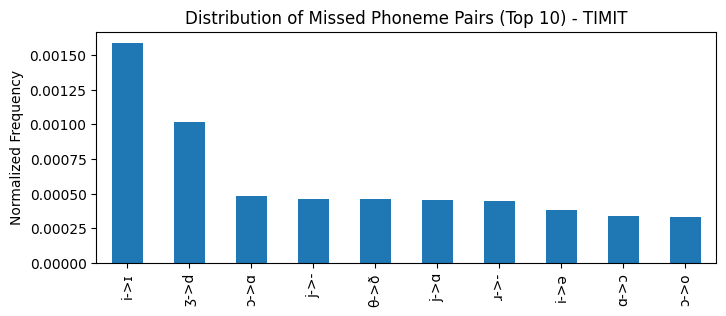

In [26]:
# plot the distribution of phoneme pairs as a bar chart stratified by dataset
for dataset, dataset_scores in scores_norm.groupby('Dataset'):
    plt.figure(figsize=(8, 3))
    pair_counts = dataset_scores[phoneme_pairs].mean()
    pair_counts.sort_values(ascending=False, inplace=True)
    pair_counts.head(10).plot(kind='bar')
    plt.title('Distribution of Missed Phoneme Pairs (Top 10) - ' + str(dataset))
    plt.ylabel('Normalized Frequency')
    plt.show()

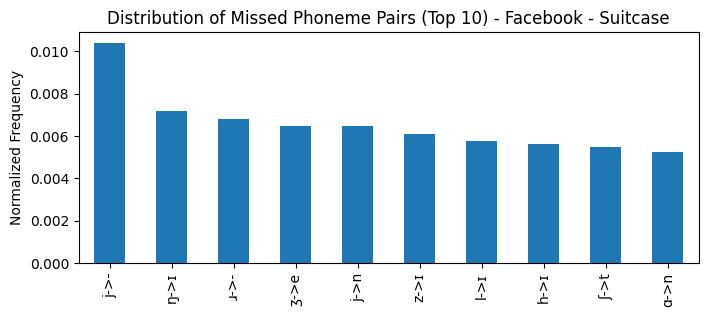

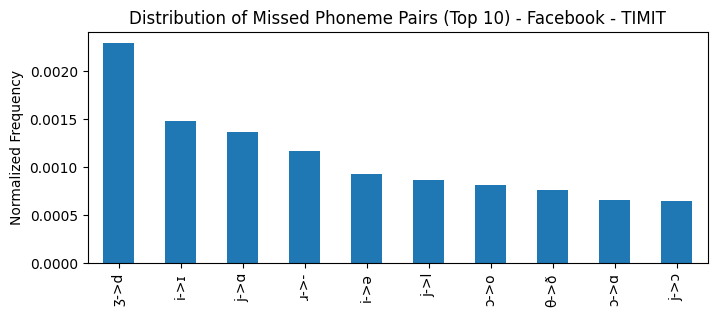

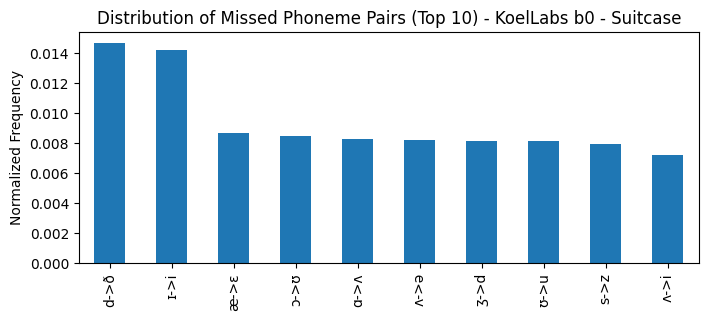

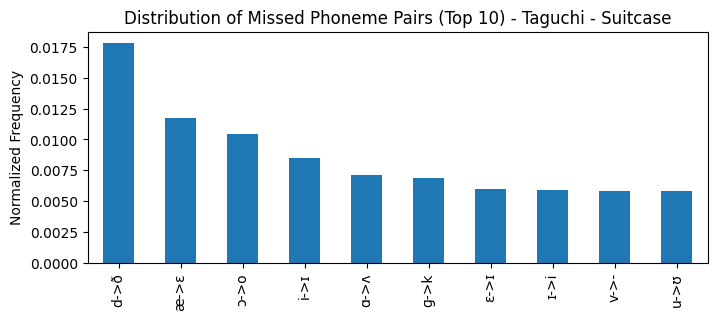

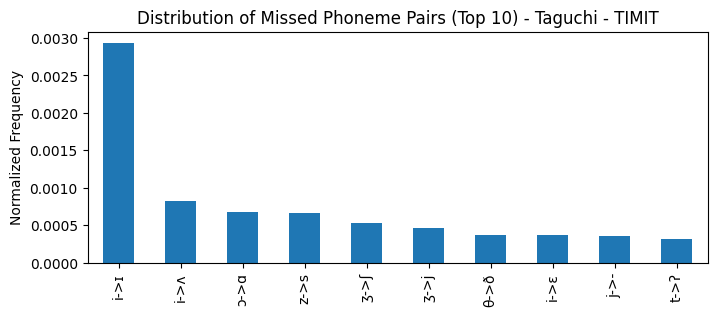

In [27]:
# plot the distribution of phoneme pairs as a bar chart stratified by dataset and model
for (model, dataset), model_dataset_scores in scores_norm.groupby(['Model', 'Dataset']):
    plt.figure(figsize=(8, 3))
    pair_counts = model_dataset_scores[phoneme_pairs].mean()
    pair_counts.sort_values(ascending=False, inplace=True)
    pair_counts.head(10).plot(kind='bar')
    plt.title('Distribution of Missed Phoneme Pairs (Top 10) - ' + str(model) + ' - ' + str(dataset))
    plt.ylabel('Normalized Frequency')
    plt.show()

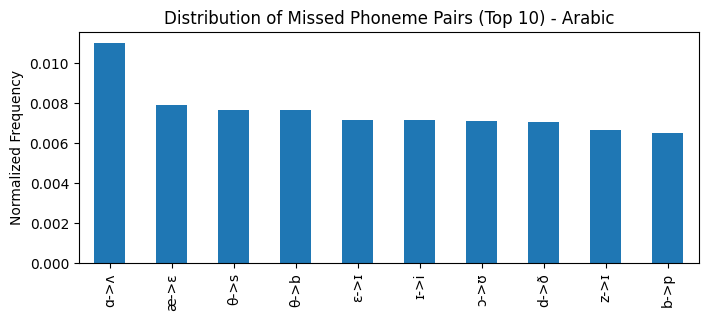

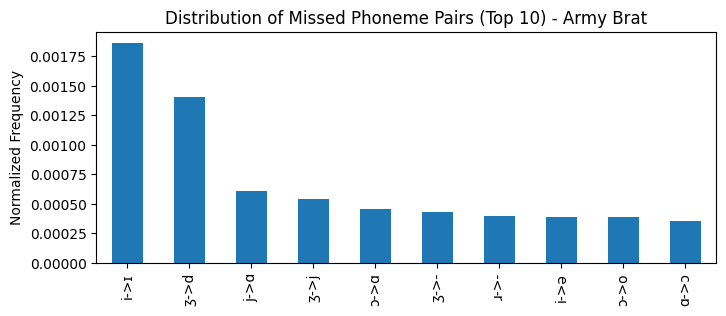

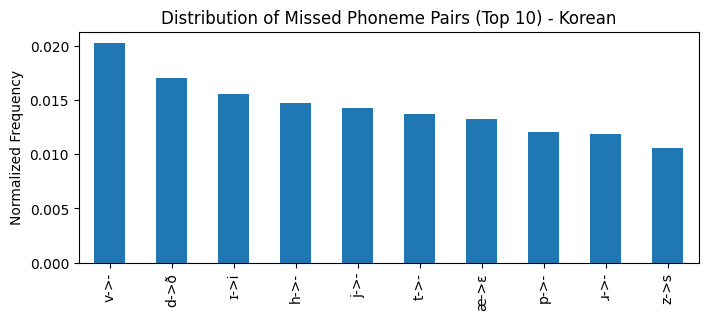

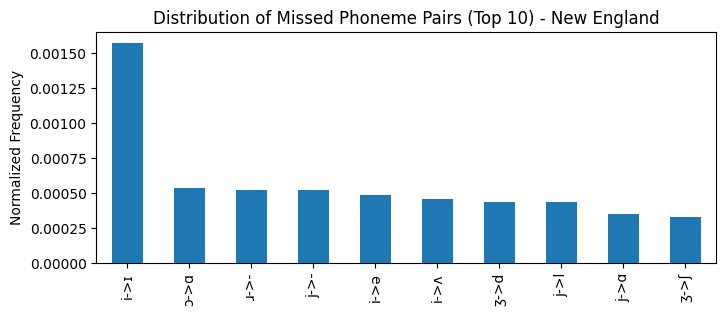

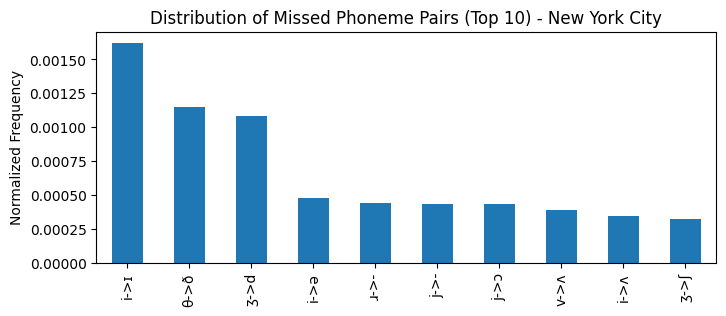

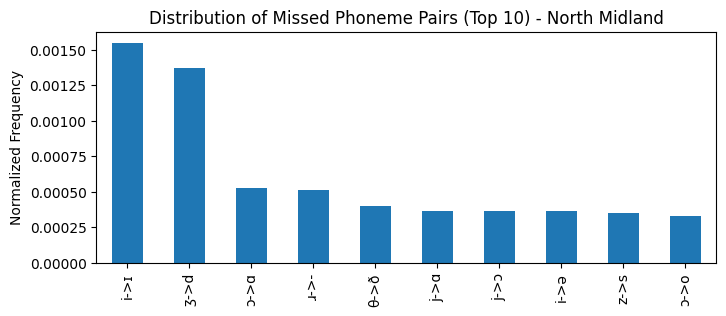

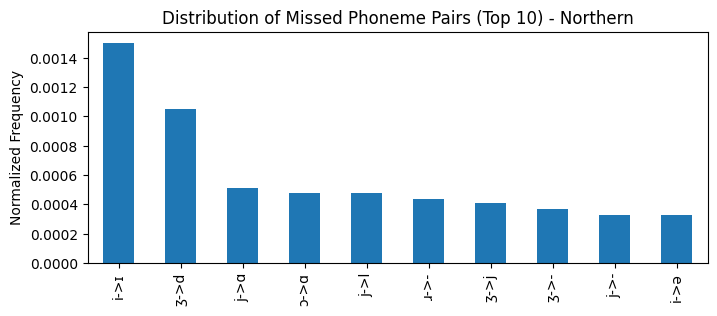

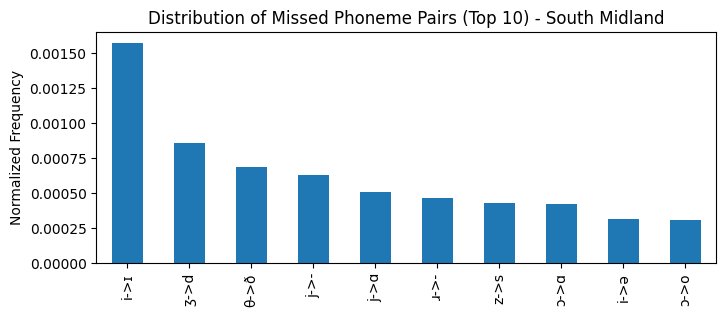

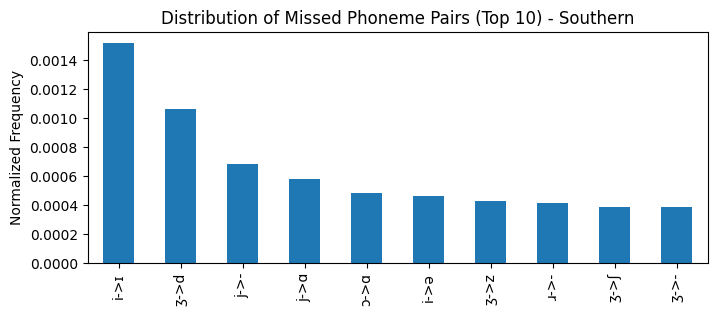

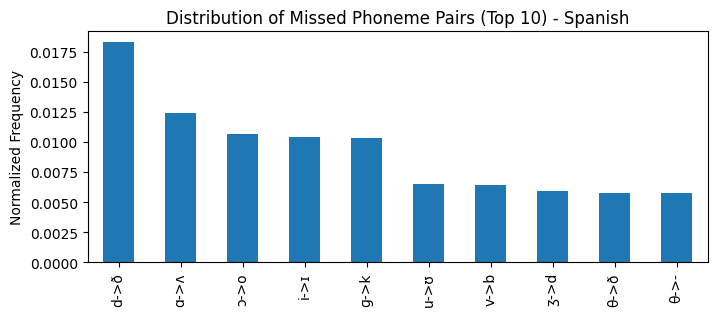

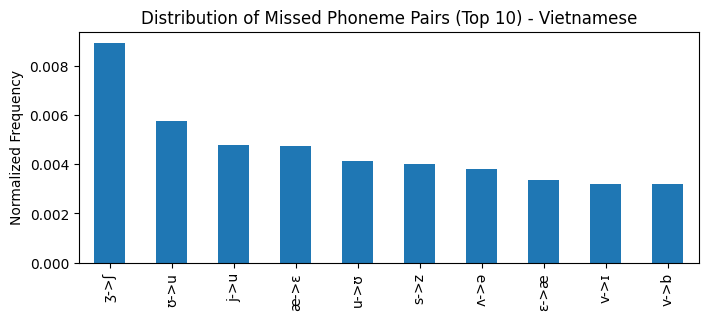

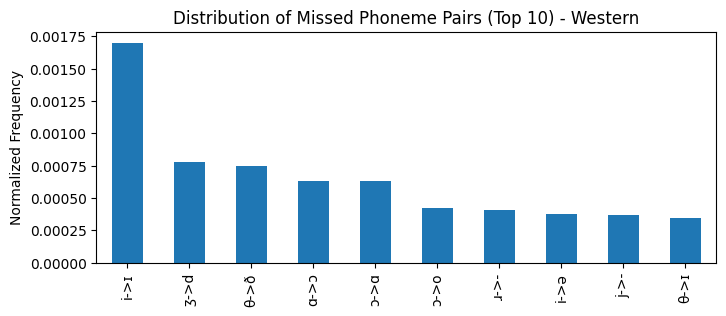

In [28]:
# plot the distribution of phoneme pairs as a bar chart stratified by background
for background, background_scores in scores_norm.groupby('Background'):
    plt.figure(figsize=(8, 3))
    pair_counts = background_scores[phoneme_pairs].mean()
    pair_counts.sort_values(ascending=False, inplace=True)
    pair_counts.head(10).plot(kind='bar')
    plt.title('Distribution of Missed Phoneme Pairs (Top 10) - ' + str(background))
    plt.ylabel('Normalized Frequency')
    plt.show()

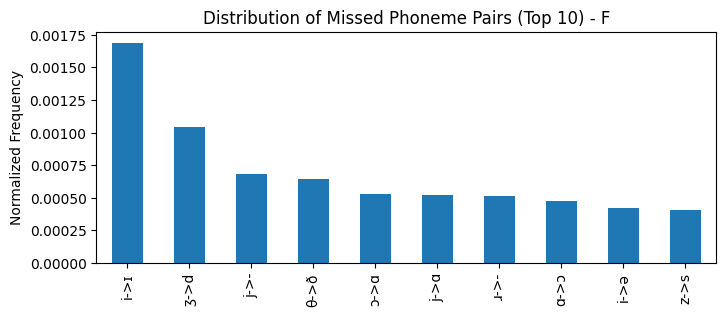

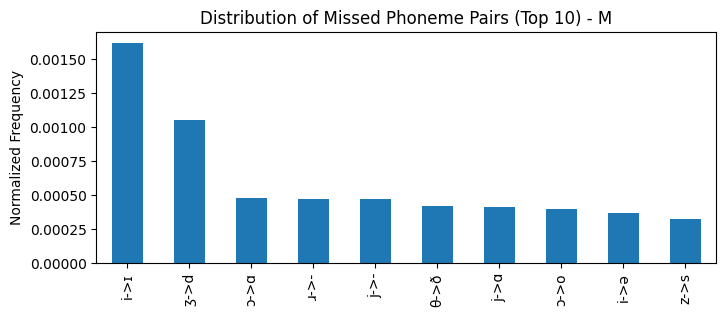

In [29]:
# plot the distribution of phoneme pairs as a bar chart stratified by gender
for gender, gender_scores in scores_norm.groupby('Gender'):
    plt.figure(figsize=(8, 3))
    pair_counts = gender_scores[phoneme_pairs].mean()
    pair_counts.sort_values(ascending=False, inplace=True)
    pair_counts.head(10).plot(kind='bar')
    plt.title('Distribution of Missed Phoneme Pairs (Top 10) - ' + str(gender))
    plt.ylabel('Normalized Frequency')
    plt.show()

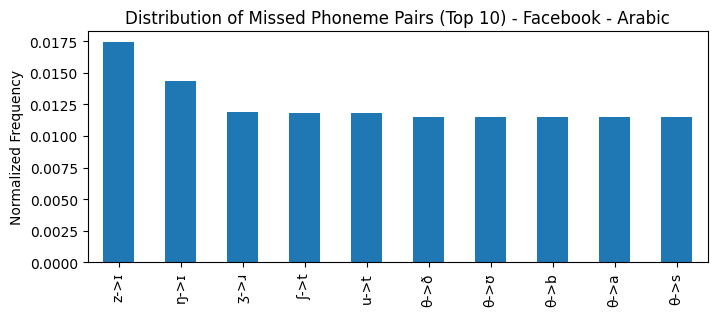

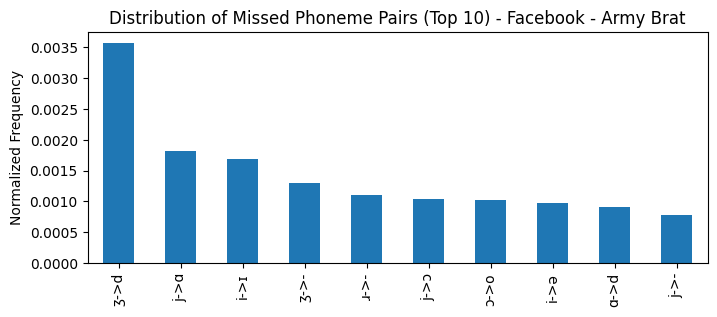

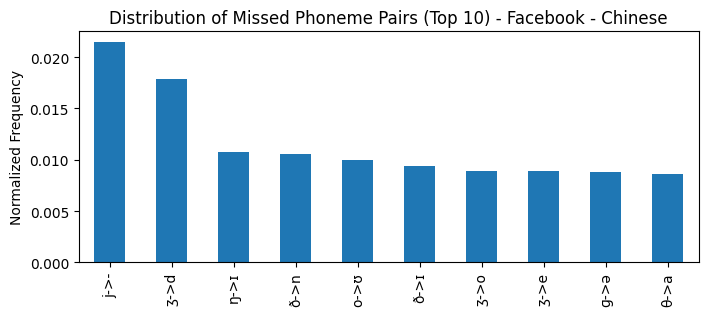

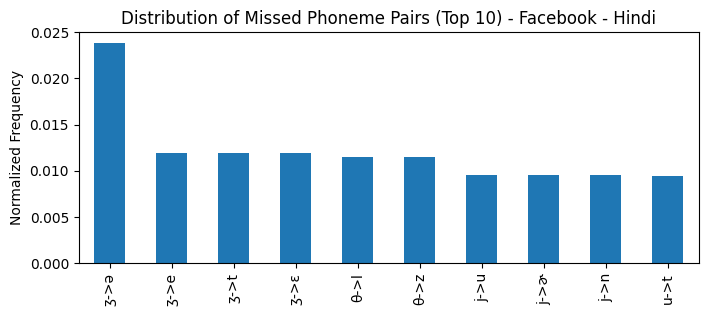

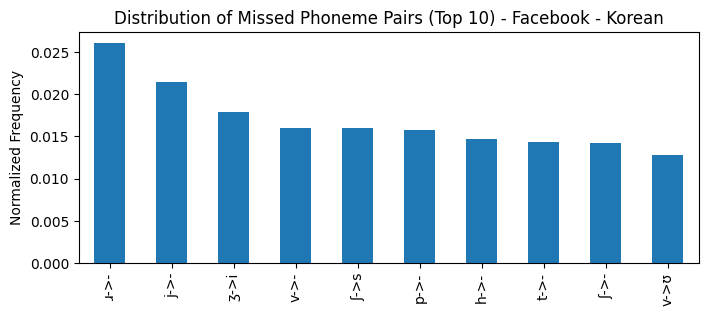

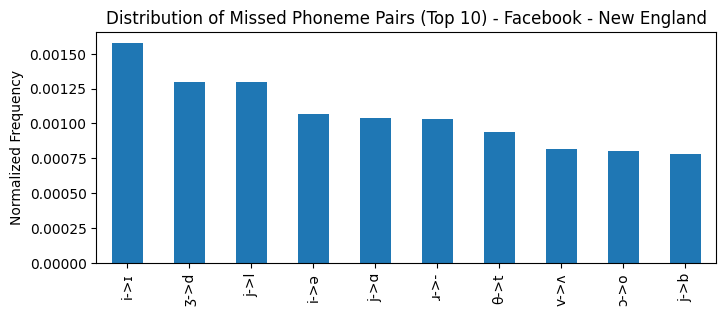

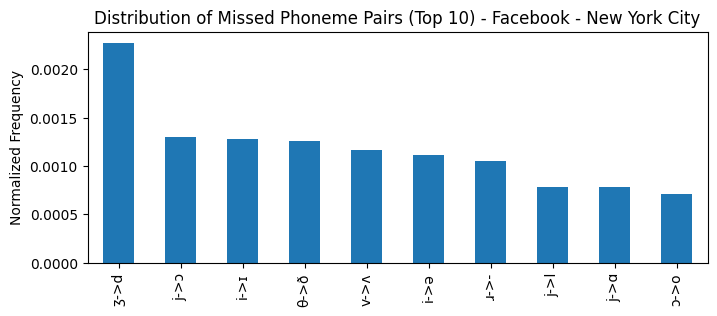

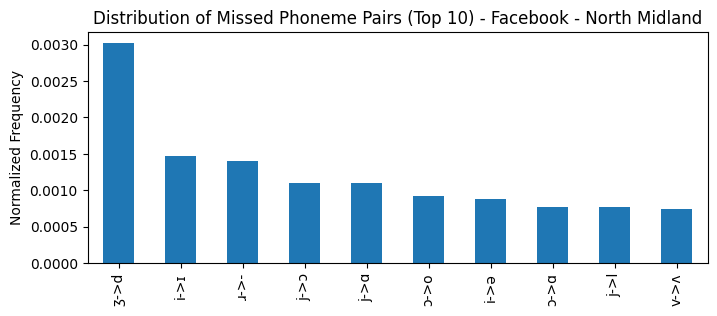

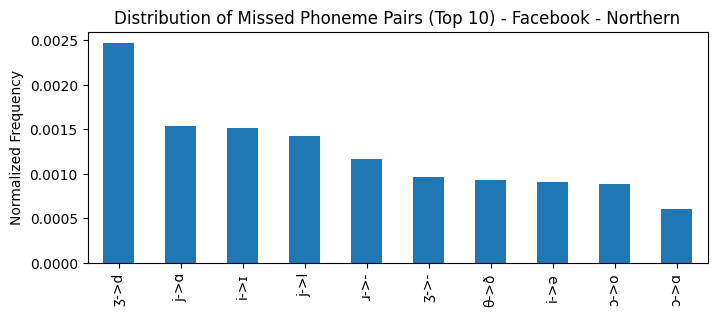

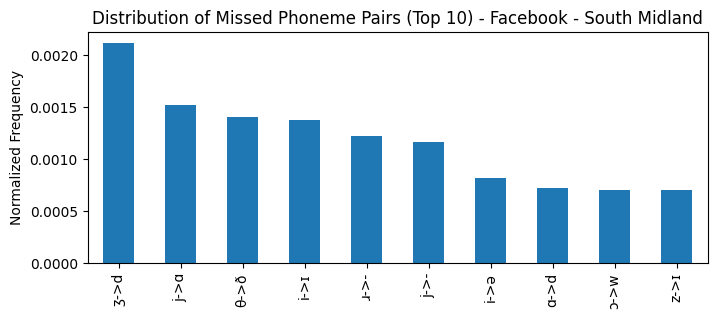

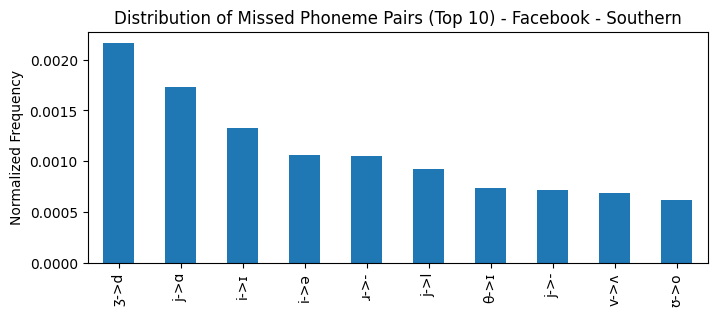

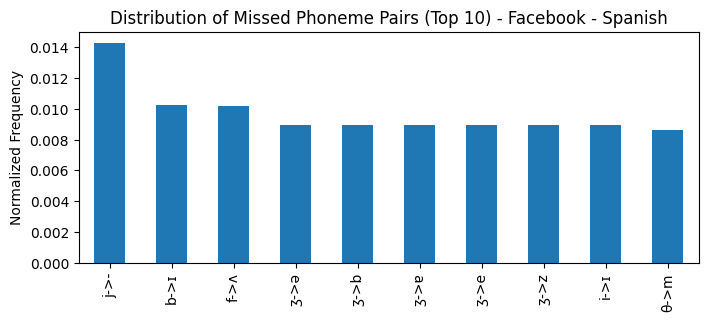

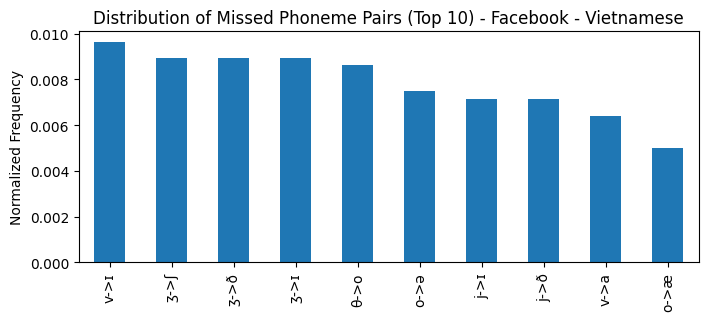

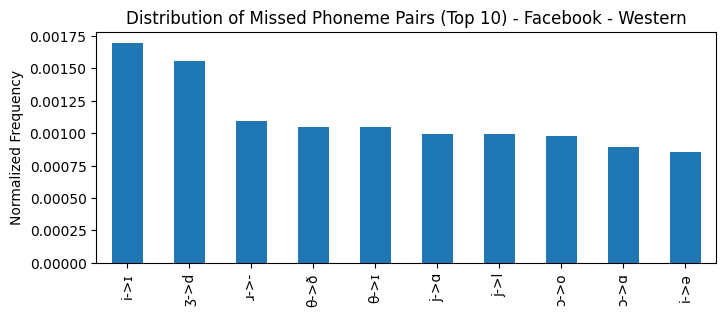

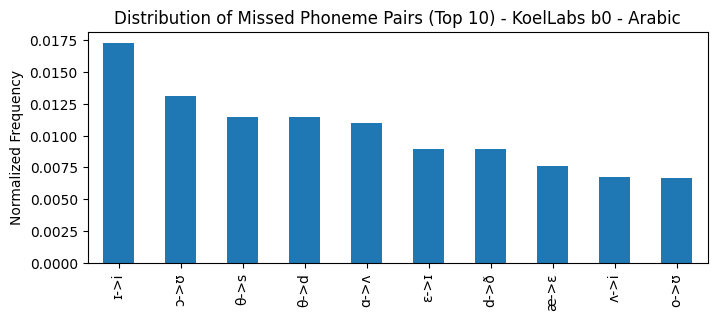

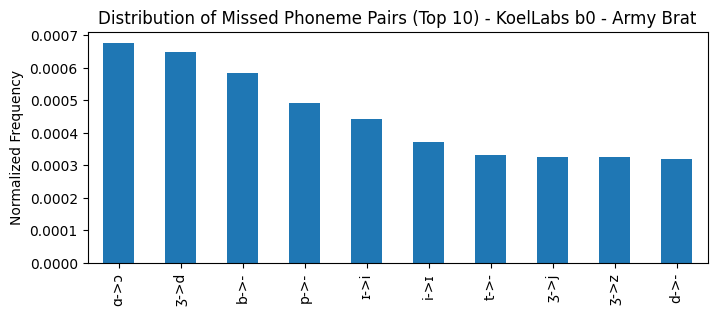

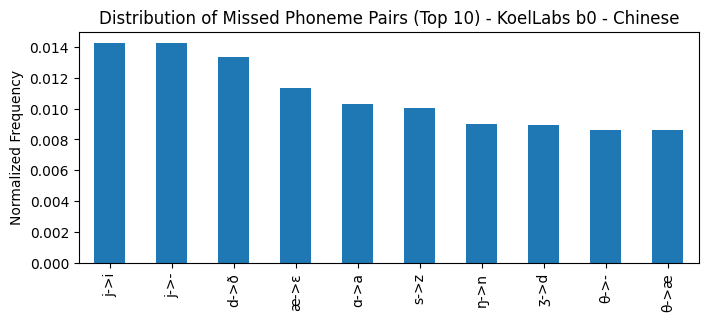

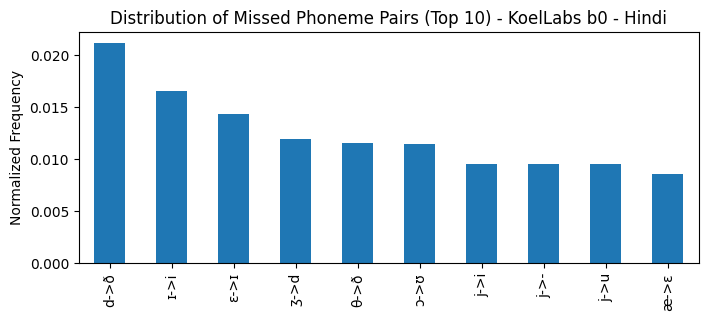

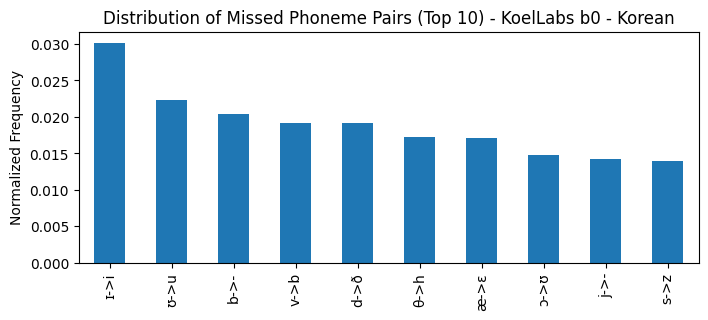

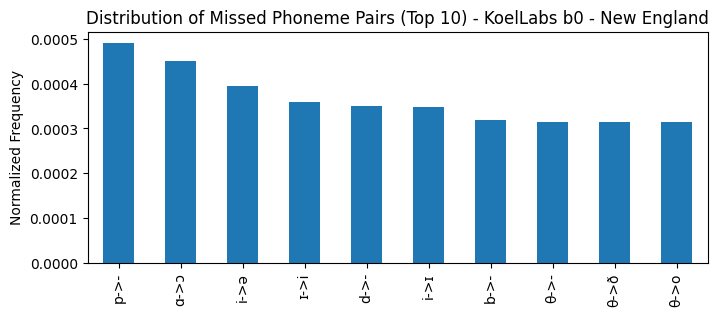

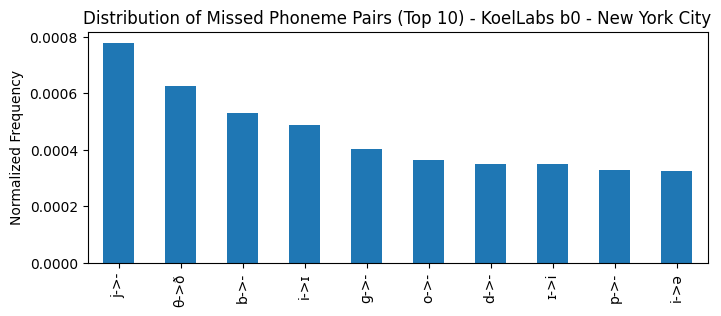

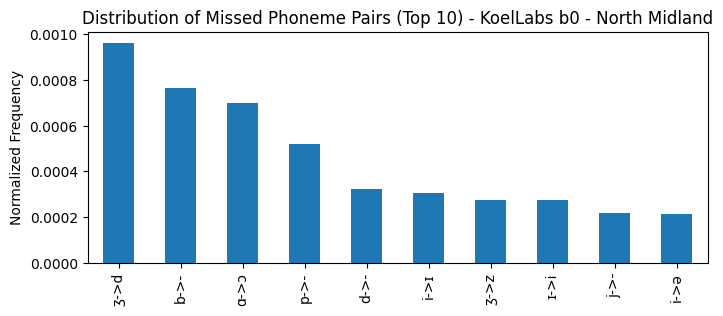

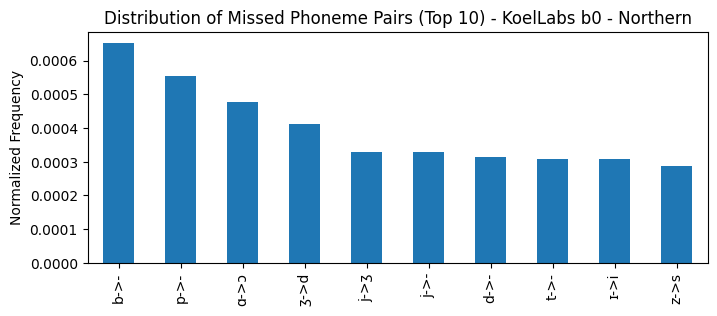

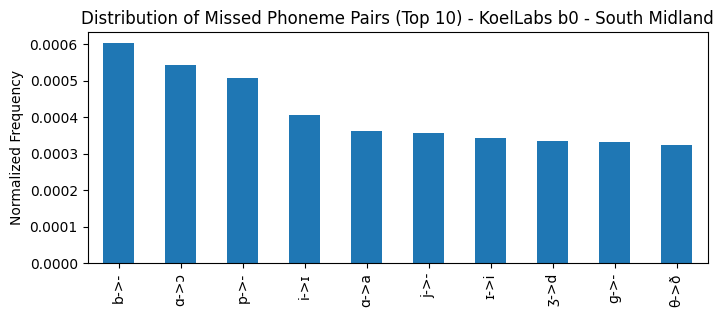

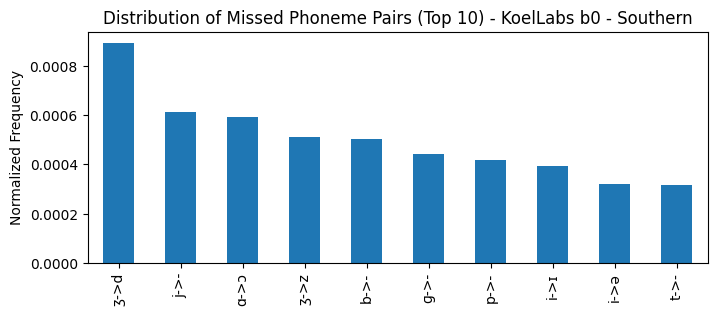

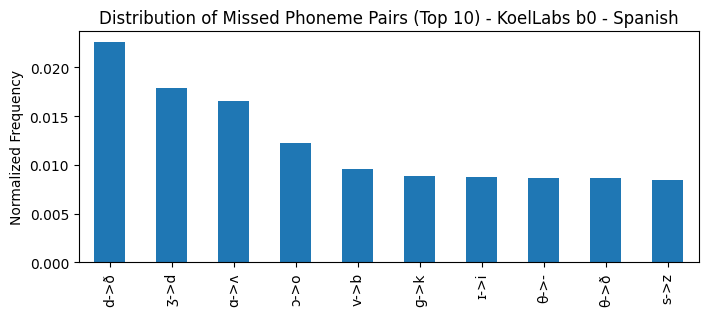

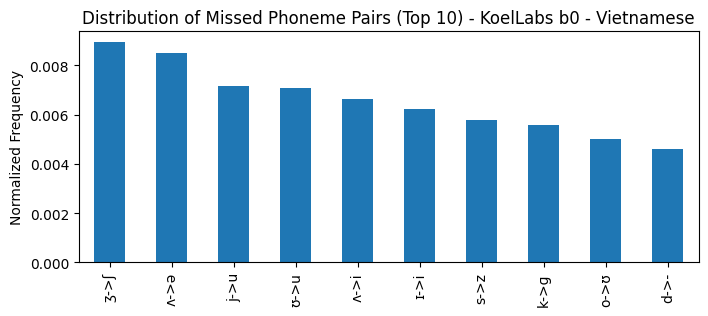

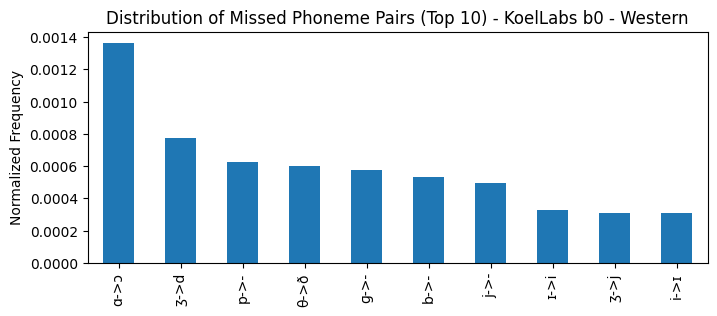

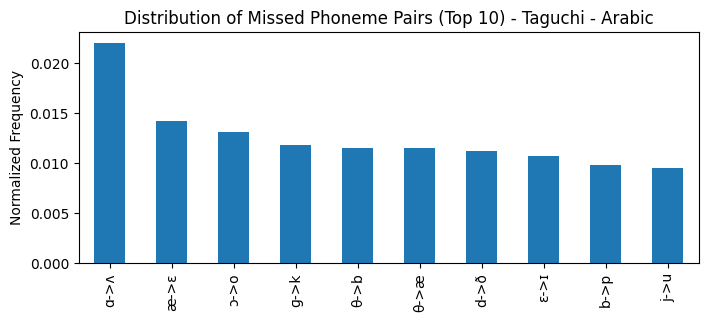

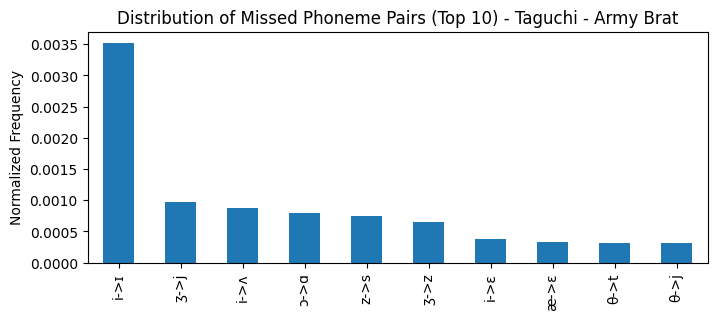

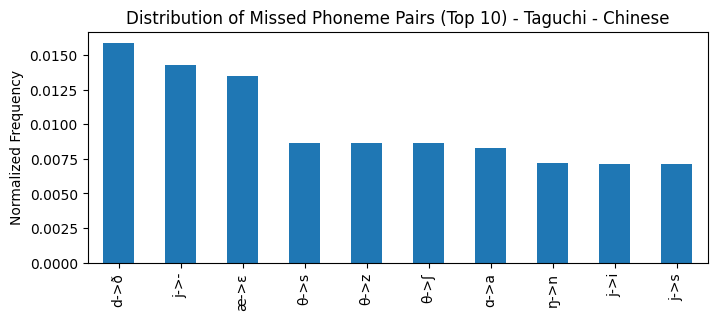

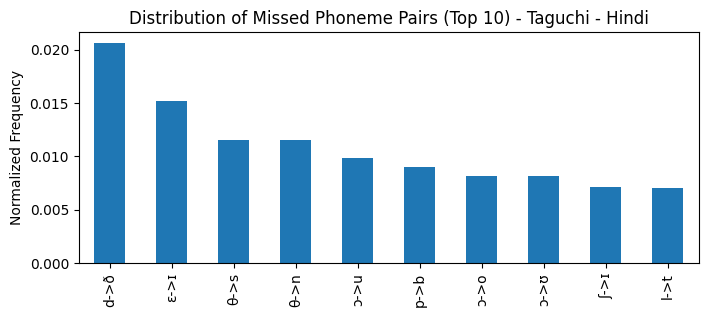

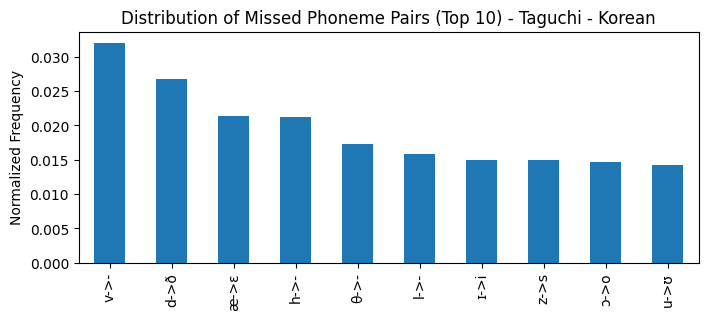

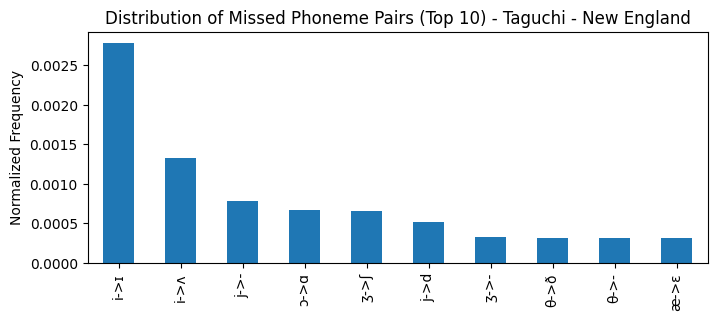

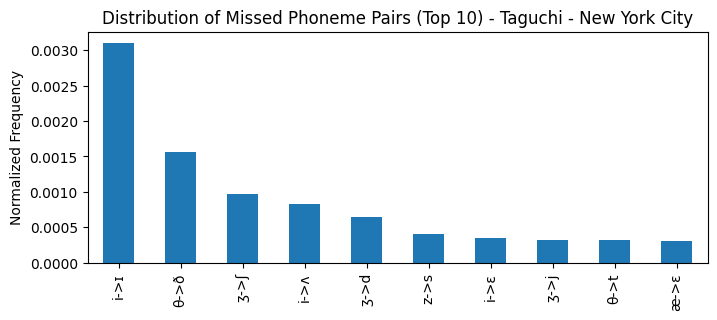

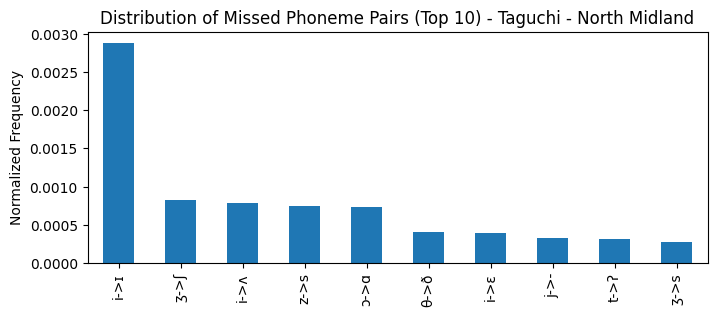

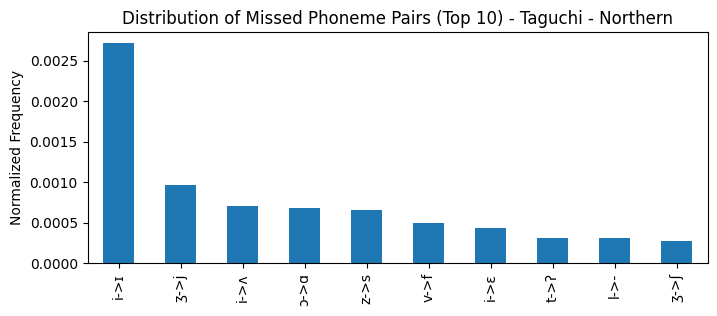

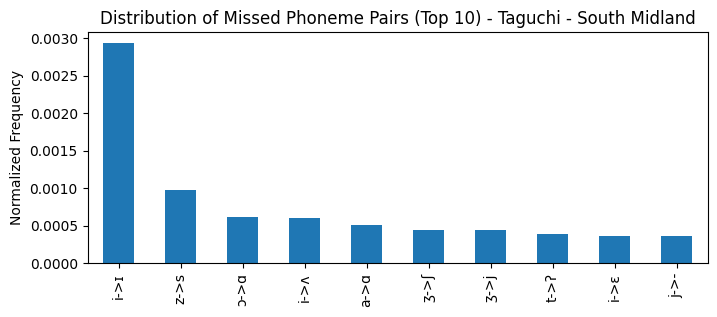

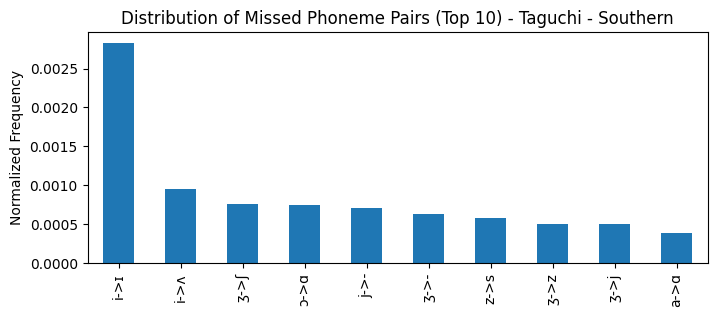

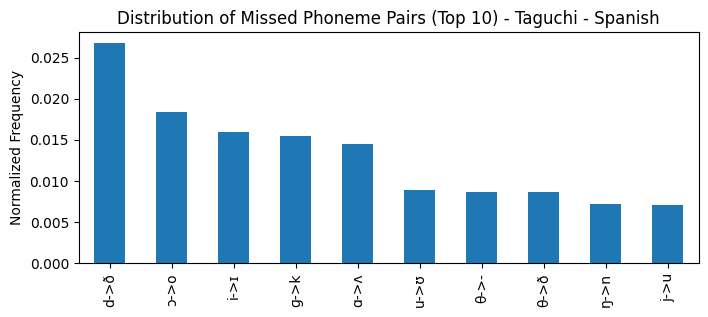

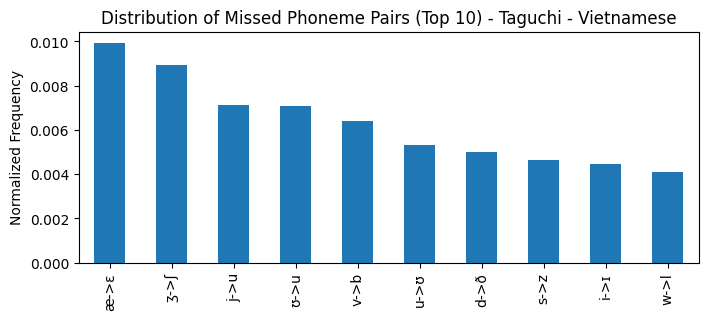

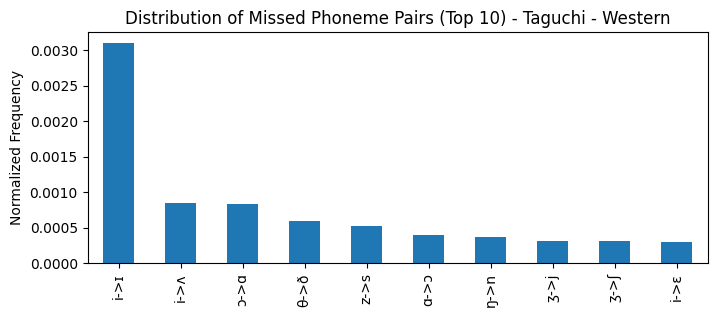

In [30]:
# plot the distribution of phoneme pairs as a bar chart stratified by background and model
for (model, background), model_background_scores in scores_norm.groupby(['Model', 'Background']):
    plt.figure(figsize=(8, 3))
    pair_counts = model_background_scores[phoneme_pairs].mean()
    pair_counts.sort_values(ascending=False, inplace=True)
    pair_counts.head(10).plot(kind='bar')
    plt.title('Distribution of Missed Phoneme Pairs (Top 10) - ' + str(model) + ' - ' + str(background))
    plt.ylabel('Normalized Frequency')
    plt.show()